# Stock Predictor RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [1]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### load in and normalize the dataset
dataset = np.loadtxt('data/normalized_apple_prices.csv')

Lets take a quick look at the (normalized) time series we'll be performing predictions on.

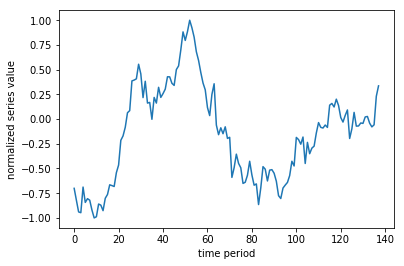

In [2]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  